In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('traininingdata.txt', sep=';')
test_data = pd.read_csv('testdata.txt', sep=';')

# 0. Data Exploration

In [4]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,divorced,secondary,no,-78,yes,yes,cellular,29,jul,10,23,-1,0,unknown,no
1,50,management,married,tertiary,no,106,yes,no,unknown,15,may,388,2,-1,0,unknown,no
2,47,admin.,married,secondary,no,407,yes,no,unknown,5,jun,67,12,-1,0,unknown,no
3,39,admin.,divorced,secondary,no,952,yes,no,unknown,16,jun,62,1,-1,0,unknown,no
4,30,management,single,tertiary,no,364,no,no,cellular,30,apr,306,2,-1,0,unknown,yes


## Check whether there is null value

In [5]:
print(f"Train Set has {train_data.isnull().any().sum()} null values")
print(f"Test Set has {test_data.isnull().any().sum()} null values")

Train Set has 0 null values
Test Set has 0 null values


The dataset is complete without null values. Here, we treat every ``"unknown"`` value as a kind of that variable.

In [6]:
ctg_features=['job', 'default', 'education','contact', 'housing', 'loan','marital', 'month', 'poutcome']
dic={}
for i in ctg_features:
    label,num=np.unique(train_data[i],return_counts=True)
    if "unknown" in label:
        dic[i]=num[np.where(label=="unknown")]
        print("The number of 'unknown'in "+i+":"+str(dic[i]))

The number of 'unknown'in job:[232]
The number of 'unknown'in education:[1496]
The number of 'unknown'in contact:[10458]
The number of 'unknown'in poutcome:[29623]


## Check whether duplicates exist

In [7]:
print(f"Train Set has {train_data.duplicated().any().sum()} duplicated values")
print(f"Test Set has {test_data.duplicated().any().sum()} duplicated values")

Train Set has 0 duplicated values
Test Set has 0 duplicated values


## Check whether the data is balanced

In [8]:
print(f'the distribution of y in train:\n{train_data.y.value_counts()/len(train_data)}')
print(f'the distribution of y in test:\n{test_data.y.value_counts()/len(test_data)}')

the distribution of y in train:
no     0.883018
yes    0.116982
Name: y, dtype: float64
the distribution of y in test:
no     0.883003
yes    0.116997
Name: y, dtype: float64


As we can see, it's very imbalanced. The ratio of `'No'`:`'Yes'` reaches almost 8:1.

## Description

In [9]:
print(train_data.describe(include='all'))

                 age          job  marital  education default        balance  \
count   36168.000000        36168    36168      36168   36168   36168.000000   
unique           NaN           12        3          4       2            NaN   
top              NaN  blue-collar  married  secondary      no            NaN   
freq             NaN         7804    21795      18556   35518            NaN   
mean       40.942076          NaN      NaN        NaN     NaN    1365.055989   
std        10.616610          NaN      NaN        NaN     NaN    3098.191637   
min        18.000000          NaN      NaN        NaN     NaN   -8019.000000   
25%        33.000000          NaN      NaN        NaN     NaN      72.000000   
50%        39.000000          NaN      NaN        NaN     NaN     448.000000   
75%        48.000000          NaN      NaN        NaN     NaN    1422.250000   
max        95.000000          NaN      NaN        NaN     NaN  102127.000000   

       housing   loan   contact        

In [10]:
#classify the features into continuous type(ctn) and categorical type(ctg)
ctn_features=['age', 'balance','day','duration','campaign', 'pdays', 'previous']
ctg_features=['contact', 'default', 'education', 'housing', 'job', 'loan','marital', 'month', 'poutcome']

## Visualization

In this part, we will characterize each of the features and show their dependencies to result of campaign directly.

### Numerical Features

/var/folders/0j/9nsyx6v509n_yf1lsgzx6hy80000gn/T/ipykernel_74461/2141766623.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data[ctn_features[i]][train_data.y=='yes'],hist = True, kde = True,ax=ax[i//4][i%4])
/var/folders/0j/9nsyx6v509n_yf1lsgzx6hy80000gn/T/ipykernel_74461/2141766623.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwasko

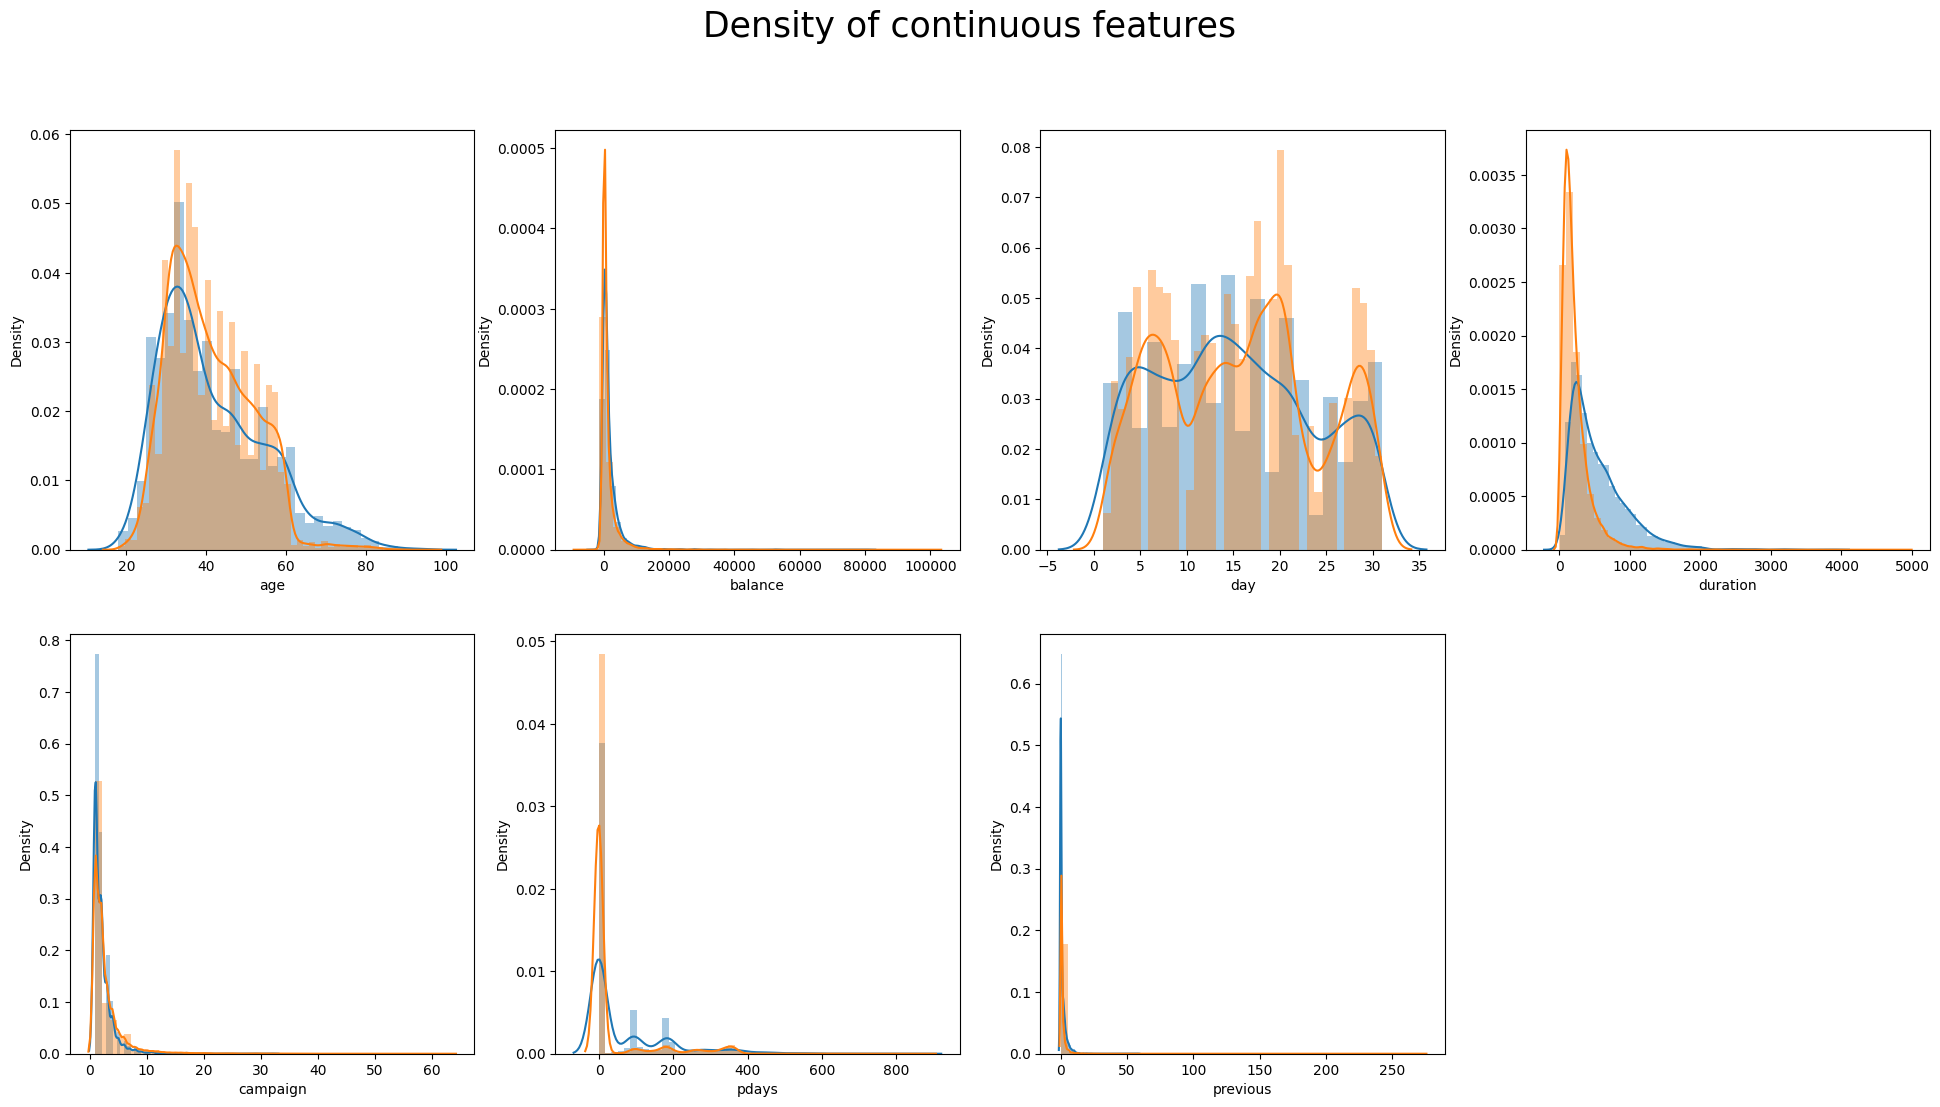

In [11]:
fig, ax = plt.subplots(2,4, figsize=(24,12))
for i in range(len(ctn_features)):
    #sn.kdeplot(x=ctn_features[i],hue='y',shade=True,data=train,ax=ax[i//4][i%4])
    sns.distplot(train_data[ctn_features[i]][train_data.y=='yes'],hist = True, kde = True,ax=ax[i//4][i%4])
    sns.distplot(train_data[ctn_features[i]][train_data.y=='no'],hist=True,kde=True,ax=ax[i//4][i%4])
    plt.legend(['yes', 'no'],prop={'size':2})
    plt.xlim([train_data[ctn_features[i]].quantile(0.001),train_data[ctn_features[i]].quantile(0.95)])
plt.suptitle("Density of continuous features",fontsize=25)
fig.delaxes(ax[1,3]) #
plt.savefig("ctn_featr.png", dpi=750, bbox_inches = 'tight')#transparent=True

look into ineresting variables:

- age

/var/folders/0j/9nsyx6v509n_yf1lsgzx6hy80000gn/T/ipykernel_74461/3648792647.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['age'][train_data.y=='yes'],hist = True, kde = True)
/var/folders/0j/9nsyx6v509n_yf1lsgzx6hy80000gn/T/ipykernel_74461/3648792647.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750

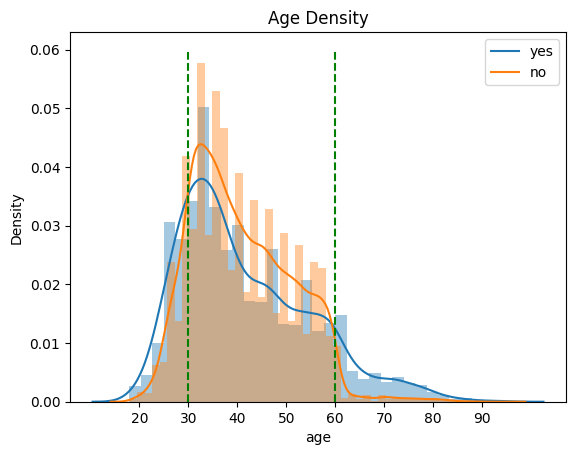

In [12]:
sns.distplot(train_data['age'][train_data.y=='yes'],hist = True, kde = True)
sns.distplot(train_data['age'][train_data.y=='no'],hist=True,kde=True)
plt.legend(['yes', 'no'])
plt.xticks([20,30,40,50,60,70,80,90])
plt.vlines(30,0,0.06,ls='dashed',color='g')
plt.vlines(60,0,0.06,ls='dashed',color='g')
plt.title('Age Density')
plt.savefig("age_distr.png", dpi=750, bbox_inches = 'tight')#transparent=True

In [13]:
blue=sns.color_palette("Paired",8)[0]
orange=sns.color_palette("Paired",8)[7]

In [18]:
help(sns.boxplot)

Help on function boxplot in module seaborn.categorical:

boxplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None, **kwargs)
    Draw a box plot to show distributions with respect to categories.
    
    A box plot (or box-and-whisker plot) shows the distribution of quantitative
    data in a way that facilitates comparisons between variables or across
    levels of a categorical variable. The box shows the quartiles of the
    dataset while the whiskers extend to show the rest of the distribution,
    except for points that are determined to be "outliers" using a method
    that is a function of the inter-quartile range.
    
    .. note::
        This function always treats one of the variables as categorical and
        draws data at ordinal positions (0, 1, ... n) on the relevant axis,
        even when the data has a numeric or date type.

In [19]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(train_data['y'],train_data['age'],palette=my_pal)
plt.title('Age Boxplot')
plt.savefig("age_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

TypeError: boxplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

we can see that when `age` > 60 or `age` < 25 , the tail of `yes` is thicker than `no`. It means that the elders and the youth tend to buy the product, which seems reasonable because the two groups are more persuassive. 

Thus, we can divide `age` into < 25, 25 to 60, >60 three subgroups.

- duration

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


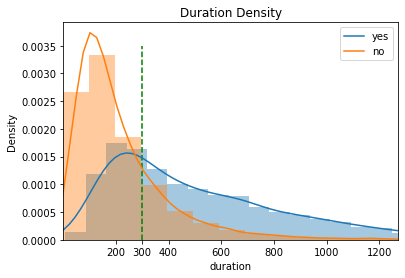

In [ ]:
sns.distplot(train_data['duration'][train_data.y=='yes'],hist = True, kde = True)
sns.distplot(train_data['duration'][train_data.y=='no'],hist=True,kde=True)
plt.xlim([0,train_data.duration.quantile(0.99)])
plt.legend(['yes', 'no'])
plt.vlines(300,0,0.0035,color='g',ls='dashed')
plt.xticks([200,300,400,600,800,1000,1200])
plt.title("Duration Density")
plt.savefig("duration_distr.png", dpi=750, bbox_inches = 'tight')#transparent=True

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


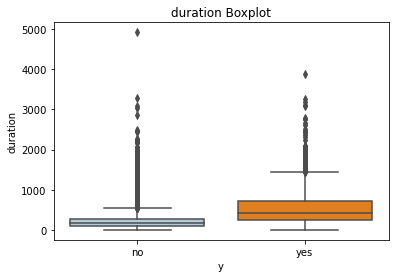

In [ ]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(train_data['y'],train_data['duration'],palette=my_pal)
plt.title('duration Boxplot')
plt.savefig("duration_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

- balance

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


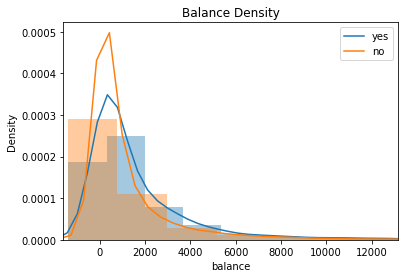

In [ ]:
sns.distplot(train_data['balance'][train_data.y=='yes'],hist = True, kde = True)
sns.distplot(train_data['balance'][train_data.y=='no'],hist=True,kde=True)
plt.xlim([train_data['balance'].quantile(0.001),train_data['balance'].quantile(0.99)])
plt.legend(['yes', 'no'])
plt.title('Balance Density')
#plt.vlines(300,0,0.0035,color='g',ls='dashed')
#plt.xticks([200,300,400,600,800,1000,1200])
plt.savefig("balance_distr.png", dpi=750, bbox_inches = 'tight')#transparent=True

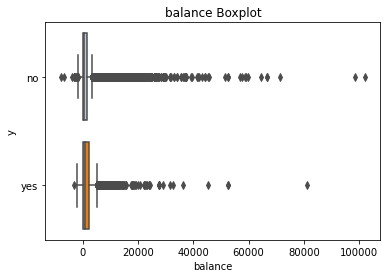

In [ ]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(y=train_data['y'],x=train_data['balance'],palette=my_pal)
plt.title('balance Boxplot')
#plt.figure(figsize=(30,10))
plt.savefig("balance_boxplot.png", dpi=750)#transparent=True

the distributions are largely overlapped, we may consider the `balance` feature not so helpful.

- campaign

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


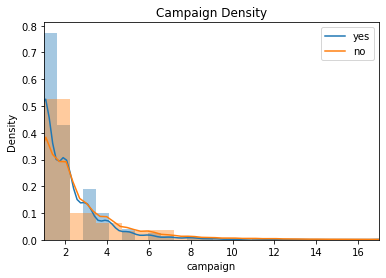

In [ ]:
sns.distplot(train_data['campaign'][train_data.y=='yes'],hist = True, kde = True)
sns.distplot(train_data['campaign'][train_data.y=='no'],hist=True,kde=True)
plt.xlim([train_data.campaign.quantile(0.01),train_data.campaign.quantile(0.99)])
plt.title('Campaign Density')
plt.legend(['yes', 'no'])
plt.savefig("Campaign_distr.png", dpi=750, bbox_inches = 'tight')

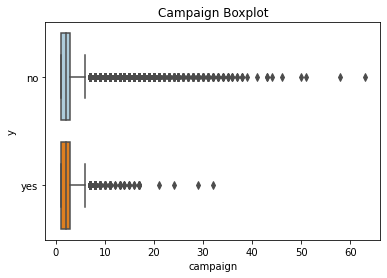

In [ ]:
my_pal = {"yes": orange, "no": blue}
sns.boxplot(y=train_data['y'],x=train_data['campaign'],palette=my_pal)
plt.title('Campaign Boxplot')
#plt.figure(figsize=(30,10))
plt.savefig("campaign_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

- previous

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


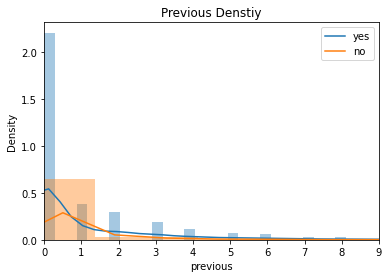

In [ ]:
vrname='previous'
sns.distplot(train_data[vrname][train_data.y=='yes'],hist=True,kde=True,bins=200)
sns.distplot(train_data[vrname][train_data.y=='no'],hist=True,kde=True,bins=200)
plt.xlim([train_data[vrname].quantile(0),train_data[vrname].quantile(0.99)])
plt.legend(['yes', 'no'])
#plt.xlim(0,7)
plt.title("Previous Denstiy")
plt.savefig(vrname+"_distr.png", dpi=750, bbox_inches = 'tight')

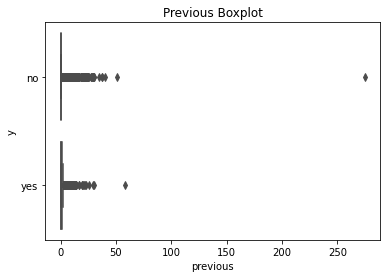

In [ ]:
sns.boxplot(y=train_data['y'],x=train_data['previous'],palette=my_pal)
plt.title('Previous Boxplot')
#plt.figure(figsize=(18,4))
plt.savefig("previous_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

- pdays

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


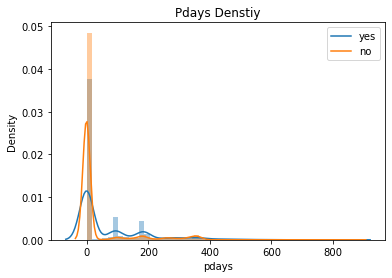

In [ ]:
vrname='pdays'
sns.distplot(train_data['pdays'][train_data.y=='yes'],hist=True,kde=True)
sns.distplot(train_data['pdays'][train_data.y=='no'],hist=True,kde=True)
#plt.xlim([train_data[vrname].quantile(0),train_data[vrname].quantile(0.99)])
plt.legend(['yes', 'no'])
#plt.xlim(0,7)
plt.title("Pdays Denstiy")
plt.savefig(vrname+"_distr.png", dpi=750, bbox_inches = 'tight')

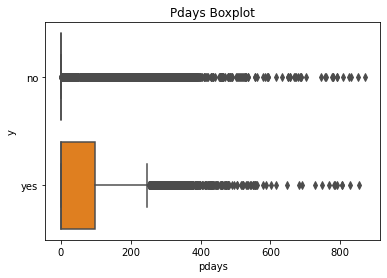

In [ ]:
sns.boxplot(y=train_data['y'],x=train_data['pdays'],palette=my_pal)
plt.title('Pdays Boxplot')
#plt.figure(figsize=(18,4))
plt.savefig("pdays_boxplot.png", dpi=750, bbox_inches = 'tight')#transparent=True

For numerical variable, we find that `age`,`duration` have different distributions between `yes` and `no` two groups. However, the other 5 features seem to have similar distributions between the two groups. Then, we try to divide `age` and `duration` into subgroups.

### Categorical Features

- job

In [ ]:
ageorder=train_data.groupby('job').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
ageorder_index=list(ageorder.index)
ageorder

job
blue-collar      0.078645
housemaid        0.090100
entrepreneur     0.090909
services         0.094496
unknown          0.120773
technician       0.123114
self-employed    0.126095
admin.           0.142426
management       0.162383
unemployed       0.184807
retired          0.298497
student          0.392193
dtype: float64

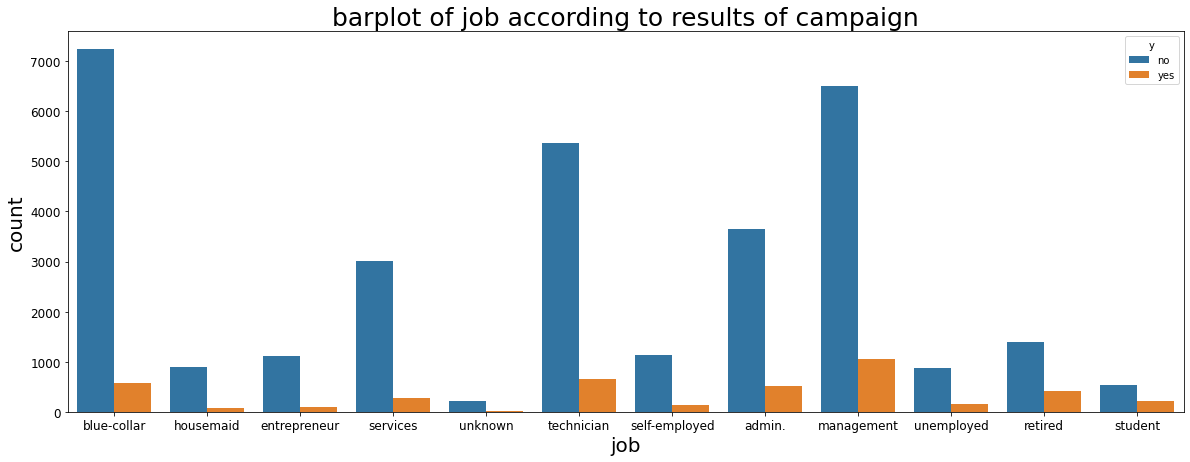

In [ ]:
plt.figure(figsize=(20, 7))
sns.countplot(x='job',hue='y',data=train_data,order=ageorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('job',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of job according to results of campaign',fontdict={'size':25})
plt.savefig("job.png", dpi=750, bbox_inches = 'tight')

Job is a categorical feature and has 12 values. The campaign were more for professions such as management, technician and blue-collar so that these professions have the highest number of product subscriptions. But when we consider about subscription rates (the ratio of `yes`:`no`), we find that the `retired` and `student` tend to buy the product, which seems reasonable because they want to deposit money. The `blue-collar` is least favorite a deposit product. Based on the ratio, we will split `job` into four subgroups later. The horizontal axis labels of the barplot are sorted by subscription scale.

- marital

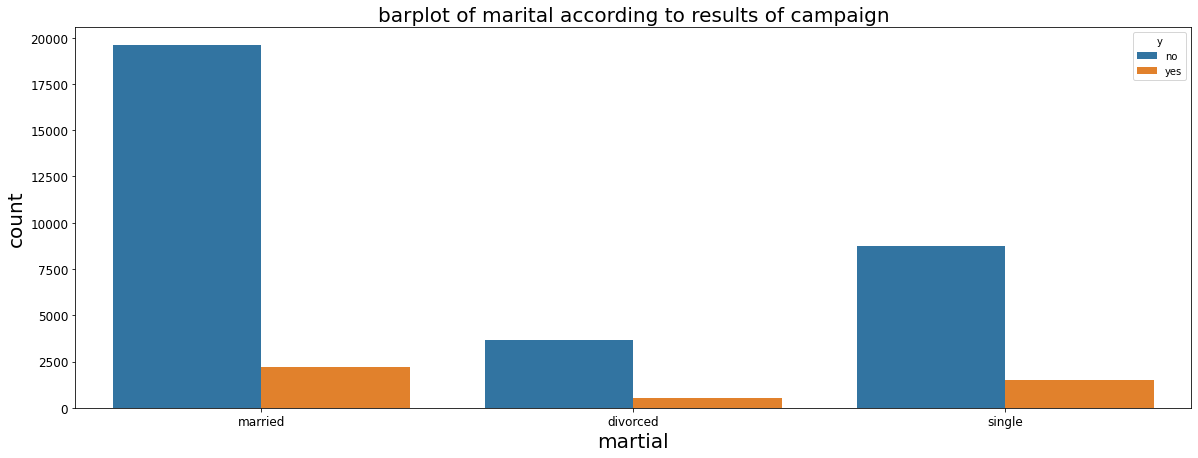

In [ ]:
marorder=train_data.groupby('marital').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
marorder_index=list(marorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='marital',hue='y',data=train_data,order=marorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('martial',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of marital according to results of campaign',fontdict={'size':20})
plt.savefig("marital.png", dpi=750, bbox_inches = 'tight')

Marital has range of the following values: 'divorced','married','single'. From the barplot above, the married has the census count with the highest subscribed and unsubscribed to a term deposit, followed by the single while the divorced has the lowest or least subscribed and unsubscribed to a term deposit.

- education

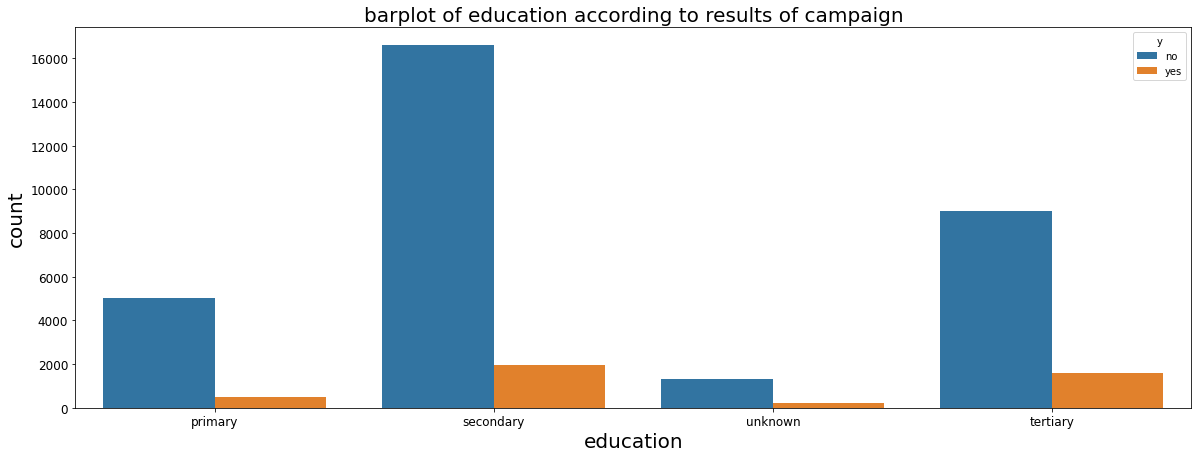

In [ ]:
eduorder=train_data.groupby('education').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
eduorder_index=list(eduorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='education',hue='y',data=train_data,order=eduorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('education',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of education according to results of campaign',fontdict={'size':20})
plt.savefig("education.png", dpi=750, bbox_inches = 'tight')

Education has four values: 'primary','secondary','tertiary','unknown'. From the barplot above, the secondary has the highest number of subscribed and unsubscribed to a term deposit, followed by the tertiary and primary. We can see that the higher the education level, the higher the subscription rate regardless of the category of unknown.

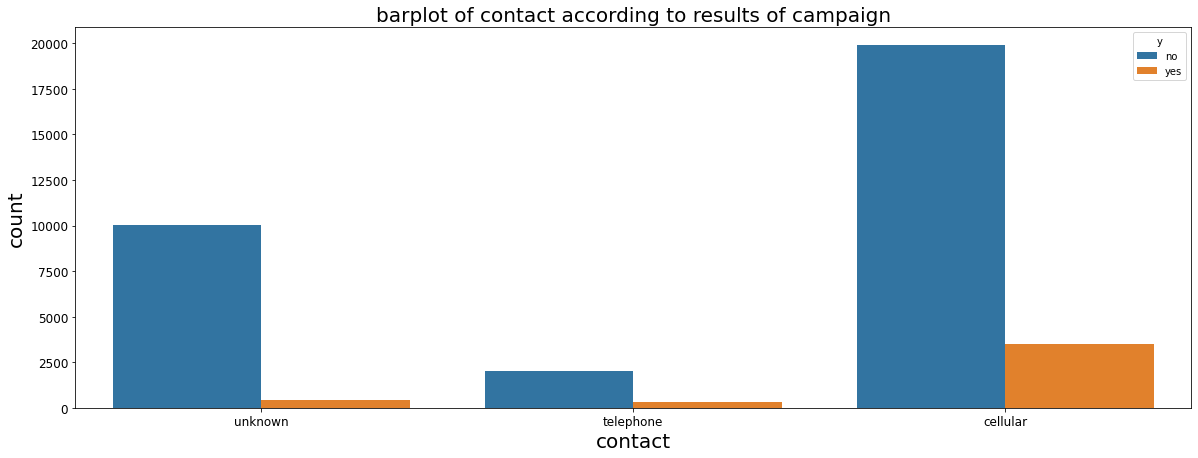

In [ ]:
conorder=train_data.groupby('contact').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
conorder_index=list(conorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='contact',hue='y',data=train_data,order=conorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('contact',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of contact according to results of campaign',fontdict={'size':20})
plt.savefig("contact.png", dpi=750, bbox_inches = 'tight')

Contact has three values: 'telephone','cellular','unknown'. From the barplot above, the cellular has the highest number of subscribed and unsubscribed to a term deposit. Also, it has the highest subscription rate.

- month

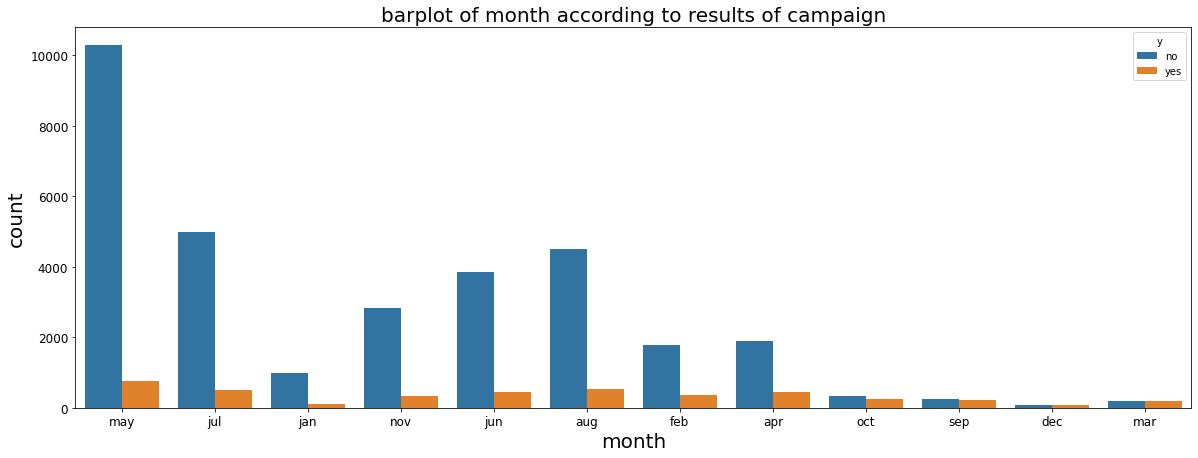

In [ ]:
monorder=train_data.groupby('month').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
monorder_index=list(monorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='month',hue='y',data=train_data,order=monorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('month',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of month according to results of campaign',fontdict={'size':20})
plt.savefig("month.png", dpi=750, bbox_inches = 'tight')

Month has 12 values from 'January' to 'December'. The contacts were the most in May, June, July and Auguest possibly due to the timing of the campaign launch. However, we guess that this feature may be less important as it does not affect or change the number of clients that
subscribed during the campaign.

- poutcome

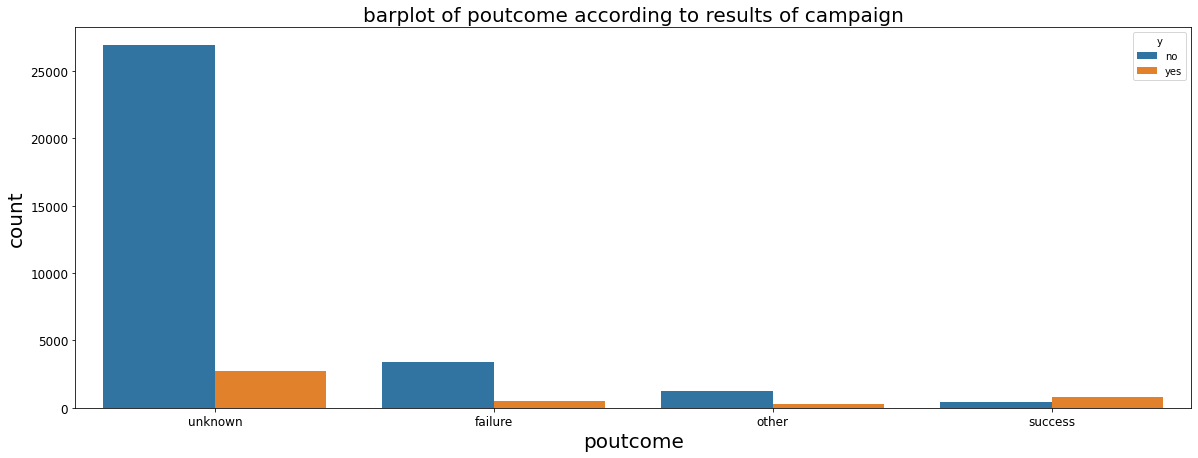

In [ ]:
poutorder=train_data.groupby('poutcome').apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
poutorder_index=list(poutorder.index)
plt.figure(figsize=(20, 7))
sns.countplot(x='poutcome',hue='y',data=train_data,order=poutorder_index)
plt.xticks(size=12,rotation=0)
plt.yticks(size=12)
plt.xlabel('poutcome',fontdict={'size':20})
plt.ylabel('count',fontdict={'size':20})
plt.title('barplot of poutcome according to results of campaign',fontdict={'size':20})
plt.savefig("poutcome.png", dpi=750, bbox_inches = 'tight')

Poutcome has four values: 'unknown','failure','other','success'. From the barplot above, the unknown has the highest number of subscribed and unsubscribed to a term deposit because it is the main category. Importantly, customers who have successfully purchased products in previous marketing campaigns are more inclined to subscribe.

- loan,housing,default<br/>
These features are all about credit, so we analyze them together.

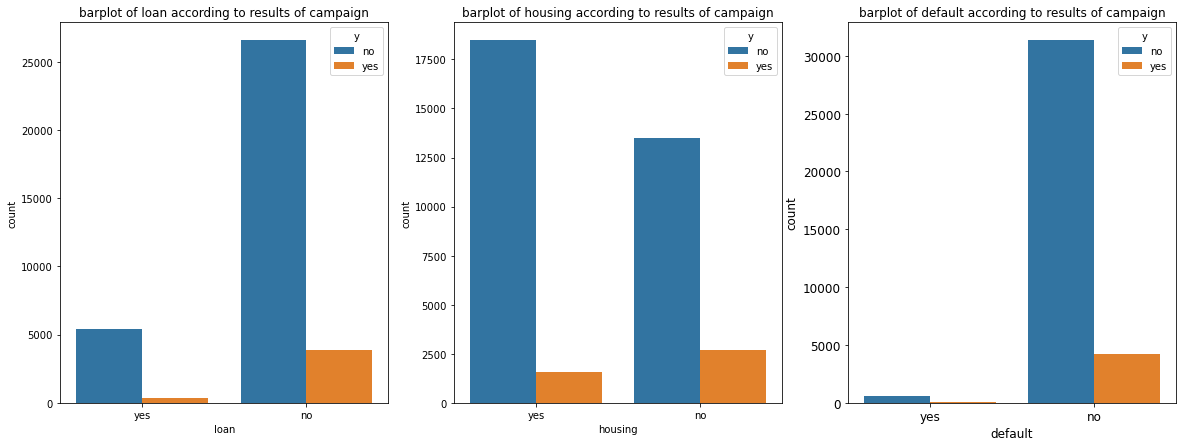

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(20,7))
feature=["loan","housing","default"]
for i in range(len(feature)):
    order=train_data.groupby(feature[i]).apply(lambda x:sum(x.y=='yes')/sum(x.y=='no')).sort_values(axis=0)
    order_index=list(order.index)
    sns.countplot(x=feature[i],hue='y',data=train_data,order=order_index,ax=ax[i])
    plt.xticks(size=12,rotation=0)
    plt.yticks(size=12)
    plt.xlabel(feature[i],fontdict={'size':12})
    plt.ylabel('count',fontdict={'size':12})
    ax[i].title.set_text('barplot of '+ str(feature[i])+' according to results of campaign')
plt.savefig("ThreeBinary.png", dpi=750, bbox_inches = 'tight')

It demonstrates that people without personal loan, housing loan and credit in default tend to subscribe the deposit. Possible reasons are less financial pressure. Moreover, the vast majority of customers have not defaulted on their credit so this feature is not very helpful in predicting results.

# 1. Preprocessing Data

## 1.1 split job into 4 groups based on label

In [ ]:
sort_job=train_data.groupby('job').apply(lambda x:sum(x.y=='yes')/len(x)).sort_values(axis=0)
low_level=tuple(sort_job[:4].index.values)
mid_level=tuple(sort_job[4:8].index.values)
advanced_level=tuple(sort_job[8:10].index.values)
high_level=tuple(sort_job[10:].index.values)

In [ ]:
train_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)
test_data.replace({'job': {**{i:1 for i in low_level}, **{i:2 for i in mid_level}, **{i:3 for i in advanced_level}, **{i:4 for i in high_level}}}, inplace=True)

## 1.2 fill 999 for -1 in pdays

In [ ]:
train_data.replace({'pdays':{-1:999}}, inplace=True)

## 1.3 Label Encode education, month, poutcome as well as label

In [ ]:
train_data.poutcome.unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [ ]:
train_data.groupby('poutcome').apply(lambda x: sum(x.y == 'yes') / len(x))

poutcome
failure    0.123765
other      0.169685
success    0.653146
unknown    0.091584
dtype: float64

In [ ]:
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
label_dict = {'yes': 1, 'no': 0}
education_dict = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
poutcome_dict = {'unknown': 0, 'other': 2, 'failure': 1, 'success': 3}

train_data['month'] = train_data.month.apply(lambda x: month_dict[x])
train_data['y'] = train_data.y.apply(lambda x: label_dict[x])
train_data['education'] = train_data.education.apply(lambda x: education_dict[x])
train_data['poutcome'] = train_data.poutcome.apply(lambda x: poutcome_dict[x])

test_data['month'] = test_data.month.apply(lambda x: month_dict[x])
test_data['y'] = test_data.y.apply(lambda x: label_dict[x])
test_data['education'] = test_data.education.apply(lambda x: education_dict[x])
test_data['poutcome'] = test_data.poutcome.apply(lambda x: poutcome_dict[x])


In [ ]:
train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,2,divorced,2,no,-78,yes,yes,cellular,29,7,10,23,999,0,0,0
1,50,3,married,3,no,106,yes,no,unknown,15,5,388,2,999,0,0,0
2,47,2,married,2,no,407,yes,no,unknown,5,6,67,12,999,0,0,0
3,39,2,divorced,2,no,952,yes,no,unknown,16,6,62,1,999,0,0,0
4,30,3,single,3,no,364,no,no,cellular,30,4,306,2,999,0,0,1


## 1.4 one-hoe encode marital, default, housing, loan and contact

In [ ]:
# one-hot encode job, default, housing, loan, contact
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['marital', 'default', 'housing', 'loan', 'contact']), remainder = 'passthrough').fit(train_data)
train_transformed = transformer.transform(train_data)
test_transformed = transformer.transform(test_data)

train_transformed = pd.DataFrame(train_transformed, columns = transformer.get_feature_names_out())
train_transformed.columns = [i.split('__')[-1] for i in train_transformed.columns]
test_transformed = pd.DataFrame(test_transformed, columns = transformer.get_feature_names_out())
test_transformed.columns = [i.split('__')[-1] for i in test_transformed.columns]

In [ ]:
test_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48.0,...,3.0,468.0,14.0,5.0,220.0,1.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,31.0,...,3.0,10215.0,22.0,8.0,139.0,2.0,-1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,45.0,...,1.0,900.0,9.0,6.0,213.0,1.0,-1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58.0,...,1.0,1231.0,20.0,6.0,21.0,3.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,35.0,...,3.0,5301.0,21.0,11.0,937.0,2.0,-1.0,0.0,0.0,1.0


## 1.5 standard-scale all numerical columns

In [ ]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
# for all other columns, cast to int after scaling
int_features = [i for i in train_transformed.columns if i not in numerical_features]

## 1.6 cast remaining columns to int

In [ ]:
train_transformed = train_transformed.astype({i:'int' for i in int_features})
test_transformed = test_transformed.astype({i:'int' for i in int_features})

In [ ]:
train_transformed.head()

,marital_divorced,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_cellular,contact_telephone,contact_unknown,age,...,education,balance,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,0,0,0,1,1,1,0,0,42.0,...,2,-78.0,29,7,10.0,23.0,999.0,0.0,0,0
1,0,1,0,0,1,0,0,0,1,50.0,...,3,106.0,15,5,388.0,2.0,999.0,0.0,0,0
2,0,1,0,0,1,0,0,0,1,47.0,...,2,407.0,5,6,67.0,12.0,999.0,0.0,0,0
3,1,0,0,0,1,0,0,0,1,39.0,...,2,952.0,16,6,62.0,1.0,999.0,0.0,0,0
4,0,0,1,0,0,0,1,0,0,30.0,...,3,364.0,30,4,306.0,2.0,999.0,0.0,0,1


## 1.7 split data

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(train_transformed.drop('y', axis = 1), train_transformed['y'], test_size=0.2,random_state=5101)
xtest, ytest = test_transformed.drop('y', axis = 1), test_transformed['y']

## 1.8 Downsample Train data to n2p = 5

In [ ]:
positive_count = sum(ytrain == 1)
negative_indexes = ytrain[ytrain == 0].sample(n = positive_count * 5, random_state=5101).index
all_indexes = negative_indexes.append(ytrain[ytrain == 1].index)


In [ ]:
xtrain_sampled = xtrain.loc[all_indexes,:]
ytrain_sampled = ytrain.loc[all_indexes]

# 1.9 Over Sample traning data using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.6,random_state=5101)
xtrain_SMOTE, ytrain_SMOTE = smote.fit_resample(xtrain, ytrain)

# 2 Fit Models

## 2.1 Decision Tree Classifier

### 2.1.1 train on unsampled data

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=5101)
dt.fit(xtrain, ytrain)

DecisionTreeClassifier(random_state=5101)

In [ ]:
dtProba = dt.predict_proba(xval)
dtPred = (dtProba[:, 1] >= 0.4).astype('int')

NameError: name 'dt' is not defined

In [ ]:
print('precision:', precision_score(yval, dtPred))
print('recall:', recall_score(yval, dtPred))
print('f1:', f1_score(yval, dtPred))
print('accuracy',accuracy_score(yval, dtPred))

precision: 0.43636363636363634
recall: 0.47820672478206727
f1: 0.4563279857397504
accuracy 0.8735139618468344


### 2.1.2 train on Downsampled Data

In [ ]:
dt2 = DecisionTreeClassifier(random_state=5101)
dt2.fit(xtrain_sampled, ytrain_sampled)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
dtProba2 = dt2.predict_proba(xval)
dtPred2 = (dtProba2[:, 1] >= 0.4).astype('int')

NameError: name 'dt2' is not defined

In [ ]:
print('precision:', precision_score(yval, dtPred2))
print('recall:', recall_score(yval, dtPred2))
print('f1:', f1_score(yval, dtPred2))
print('accuracy',accuracy_score(yval, dtPred2))

NameError: name 'yval' is not defined

### 2.1.3 train on SMOTE data

In [ ]:
dt3 = DecisionTreeClassifier(random_state=5101)
dt3.fit(xtrain_SMOTE, ytrain_SMOTE)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
dtProba3 = dt3.predict_proba(xval)
dtPred3= (dtProba3[:, 1] >= 0.4).astype('int')

NameError: name 'dt3' is not defined

In [ ]:
print('precision:', precision_score(yval, dtPred3))
print('recall:', recall_score(yval, dtPred3))
print('f1:', f1_score(yval, dtPred3))
print('accuracy',accuracy_score(yval, dtPred3))

NameError: name 'yval' is not defined

### 2.1.4 parameter tuning using downsampled dat

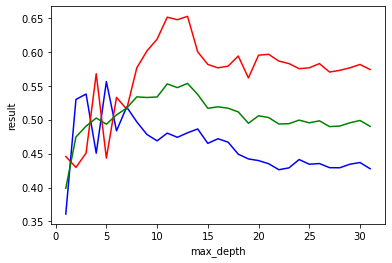

In [ ]:
#moudle tuning for max_depths using validation
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = DecisionTreeClassifier(max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   dtProba2 = model.predict_proba(xval)
   y_pred = (dtProba2[:, 1] >= 0.4).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

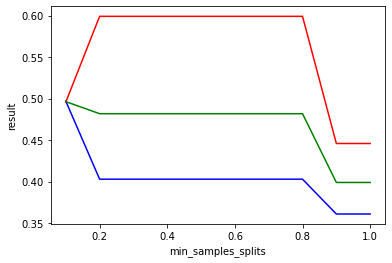

In [ ]:
#moudle tuning for min_samples_splits using validation
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = DecisionTreeClassifier(max_depth=13,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   dtProba2 = model.predict_proba(xval)
   y_pred = (dtProba2[:, 1] >= 0.4).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

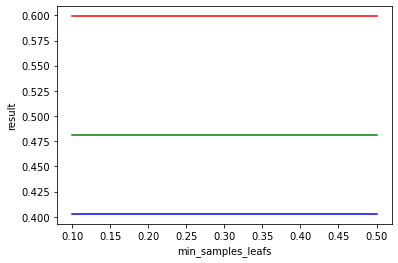

In [ ]:
#moudle tuning for min_samples_leafs using validation
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_leaf in min_samples_leafs:
   model = DecisionTreeClassifier(max_depth=13,min_samples_split=0.2,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   dtProba2 = model.predict_proba(xval)
   y_pred = (dtProba2[:, 1] >= 0.4).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_leafs, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_leafs, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_leafs')
plt.show()

# this para not cause any influence.

### 2.1.5 Apply new parameters to DCT model

In [ ]:
dt4 = DecisionTreeClassifier(max_depth=13,min_samples_split=0.4,random_state=5101)
dt4.fit(xtrain_sampled, ytrain_sampled)

DecisionTreeClassifier(max_depth=13, min_samples_split=0.4, random_state=5101)

In [ ]:
dtProba4 = dt4.predict_proba(xval)
dtPred4 = (dtProba4[:, 1] >= 0.4).astype('int')

In [ ]:
print('precision:', precision_score(yval, dtPred4))
print('recall:', recall_score(yval, dtPred4))
print('f1:', f1_score(yval, dtPred4))
print('accuracy',accuracy_score(yval, dtPred4))

precision: 0.4028475711892797
recall: 0.5990037359900373
f1: 0.48172258387581374
accuracy 0.856925628974288


## 2.2 Random Forest

### 2.2.1 train on unsampled data

In [ ]:
RFCls = RandomForestClassifier(random_state=5101, n_estimators=400, oob_score=True)
RFCls.fit(xtrain, ytrain)

RandomForestClassifier(n_estimators=400, oob_score=True, random_state=5101)

In [ ]:
RFProba = RFCls.predict_proba(xval)
RFPrediction = (RFProba[:, 1] >= 0.4).astype('int')

In [ ]:
print('precision:', precision_score(yval, RFPrediction))
print('recall:', recall_score(yval, RFPrediction))
print('f1:', f1_score(yval, RFPrediction))
print('accuracy:', accuracy_score(yval, RFPrediction))

precision: 0.565
recall: 0.5628891656288917
f1: 0.5639426076107299
accuracy: 0.9033729610174177


### 2.2.2 Train on Downsampled Data

In [ ]:
RFCls_sampled = RandomForestClassifier(random_state=5101, n_estimators=200, max_depth=350, oob_score=True)
RFCls_sampled.fit(xtrain_sampled, ytrain_sampled)

RandomForestClassifier(max_depth=350, n_estimators=200, oob_score=True,
                       random_state=5101)

In [ ]:
RFProba_sampled = RFCls_sampled.predict_proba(xval)
RFPrediction_sampled = (RFProba_sampled[:, 1] >= 0.4).astype('int')

In [ ]:
print('precision:', precision_score(yval, RFPrediction_sampled))
print('recall:', recall_score(yval, RFPrediction_sampled))
print('f1:', f1_score(yval, RFPrediction_sampled))
print('accuracy:', accuracy_score(yval, RFPrediction_sampled))

precision: 0.524733268671193
recall: 0.6737235367372354
f1: 0.5899672846237731
accuracy: 0.8960464473320431


### 2.2.3 Train on SMOTE Data

In [ ]:
RFCls_SMOTE = RandomForestClassifier(random_state=5101, n_estimators=400, max_depth=350, oob_score=True)
RFCls_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

RandomForestClassifier(max_depth=350, n_estimators=400, oob_score=True,
                       random_state=5101)

In [ ]:
RFProba_SMOTE = RFCls_SMOTE.predict_proba(xval)
RFPrediction_SMOTE = (RFProba_SMOTE[:, 1] >= 0.4).astype('int')

In [ ]:
print('precision:', precision_score(yval, RFPrediction_SMOTE))
print('recall:', recall_score(yval, RFPrediction_SMOTE))
print('f1:', f1_score(yval, RFPrediction_SMOTE))
print('accuracy:', accuracy_score(yval, RFPrediction_SMOTE))

precision: 0.5004625346901017
recall: 0.6737235367372354
f1: 0.5743099787685775
accuracy: 0.8891346419684821


## 2.3 gradient boosting classifier

### 2.3.1 train on unsampled data

In [ ]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=5101)
gbc.fit(xtrain, ytrain)

GradientBoostingClassifier(random_state=5101)

In [ ]:
gbcProba = gbc.predict_proba(xval)
gbcPred = (gbcProba[:, 1] >= 0.2).astype('int')

In [ ]:
print('precision:', precision_score(yval, gbcPred))
print('recall:', recall_score(yval, gbcPred))
print('f1:', f1_score(yval, gbcPred))
print('accuracy',accuracy_score(yval, gbcPred))

precision: 0.46843335931410757
recall: 0.7484433374844334
f1: 0.576222435282838
accuracy 0.8777992811722422


### 2.3.2 train on Downsampled Data

In [ ]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc2 = GradientBoostingClassifier(random_state=5101)
gbc2.fit(xtrain_sampled, ytrain_sampled)

GradientBoostingClassifier(random_state=5101)

In [ ]:
gbcProba2 = gbc2.predict_proba(xval)
gbcPred2 = (gbcProba2[:, 1] >= 0.3).astype('int')

In [ ]:
print('precision:', precision_score(yval, gbcPred2))
print('recall:', recall_score(yval, gbcPred2))
print('f1:', f1_score(yval, gbcPred2))
print('accuracy',accuracy_score(yval, gbcPred2))

precision: 0.48502495840266224
recall: 0.726027397260274
f1: 0.5815461346633417
accuracy 0.884019905999447


### 2.3.3 train on SMOTE Data

In [ ]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc3 = GradientBoostingClassifier(random_state=5101)
gbc3.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(random_state=5101)

In [ ]:
gbcProba3 = gbc3.predict_proba(xval)
gbcPred3 = (gbcProba3[:, 1] >= 0.4).astype('int')

In [ ]:
print('precision:', precision_score(yval, gbcPred3))
print('recall:', recall_score(yval, gbcPred3))
print('f1:', f1_score(yval, gbcPred3))
print('accuracy',accuracy_score(yval, gbcPred3))

precision: 0.48363636363636364
recall: 0.6625155666251556
f1: 0.55911718339464
accuracy 0.884019905999447


### 2.3.4 parameter tuning using downsampled data 

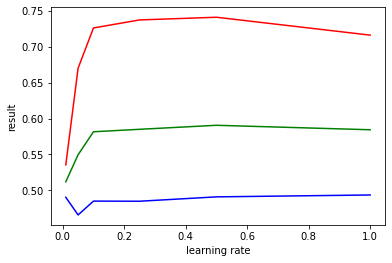

In [ ]:
#module tuning for learning rate using validation 
learning_rates = [1,0.5,0.25, 0.1, 0.05,0.01]
precision_result = []
recall_result = []
f1_result = []
for eta in learning_rates:
   model = GradientBoostingClassifier(learning_rate=eta,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, precision_result, 'b', label="precision")
line2, = plt.plot(learning_rates, recall_result, 'r', label="recall")
line3, = plt.plot(learning_rates, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('learning rate')
plt.show()

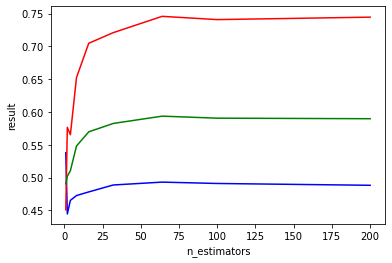

In [ ]:
#module tuning for N_estimators using validation 
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
precision_result = []
recall_result = []
f1_result = []
for estimator in n_estimators:
   model = GradientBoostingClassifier(learning_rate=0.5,n_estimators=estimator,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, precision_result, 'b', label="precision")
line2, = plt.plot(n_estimators, recall_result, 'r', label="recall")
line3, = plt.plot(n_estimators, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('n_estimators')
plt.show()

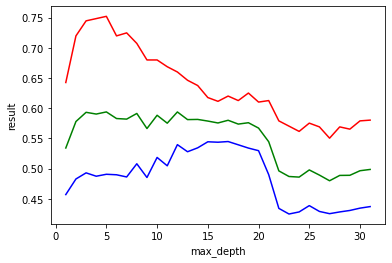

In [ ]:
#module tuning for max_depths using validation 
max_depths = np.arange(1, 32, 1)
max_depths
precision_result = []
recall_result = []
f1_result = []
for max_depth in max_depths:
   model = GradientBoostingClassifier(learning_rate=0.5,n_estimators=65,max_depth=max_depth,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, precision_result, 'b', label="precision")
line2, = plt.plot(max_depths, recall_result, 'r', label="recall")
line3, = plt.plot(max_depths, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_depth')
plt.show()

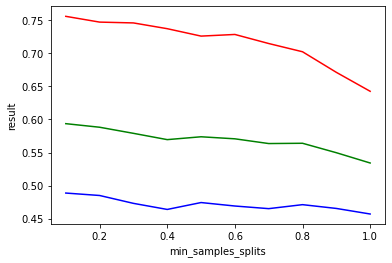

In [ ]:
#moduel tuning for min_samples_splits using validation 
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
precision_result = []
recall_result = []
f1_result = []
for min_samples_split in min_samples_splits:
   model = GradientBoostingClassifier(learning_rate=0.5,n_estimators=65,max_depth=5,min_samples_split=min_samples_split,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, precision_result, 'b', label="precision")
line2, = plt.plot(min_samples_splits, recall_result, 'r', label="recall")
line3, = plt.plot(min_samples_splits, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('min_samples_splits')
plt.show()

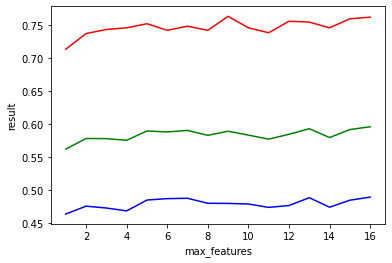

In [ ]:
#module tuning for max_features using validation 
max_features = list(range(1,train_data.shape[1]))
precision_result = []
recall_result = []
f1_result = []
for max_feature in max_features:
#  model = GradientBoostingClassifier(learning_rate=0.2,n_estimators=60,max_depth=4,min_samples_split=0.2,max_features=max_feature)
   model = GradientBoostingClassifier(learning_rate=0.5,n_estimators=65,max_depth=5,min_samples_split=0.1,max_features=max_feature,random_state=5101)
   model.fit(xtrain_sampled, ytrain_sampled)
   gbcProba2 = model.predict_proba(xval)
   y_pred = (gbcProba2[:, 1] >= 0.3).astype('int')
   precision = precision_score(yval, y_pred)
   recall = recall_score(yval, y_pred)
   f1 = f1_score(yval, y_pred)
   precision_result.append(precision)
   recall_result.append(recall)
   f1_result.append(f1)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, precision_result, 'b', label="precision")
line2, = plt.plot(max_features, recall_result, 'r', label="recall")
line3, = plt.plot(max_features, f1_result, 'g', label="f1")
plt.ylabel('result')
plt.xlabel('max_features')
plt.show()

### 2.3.5 Apply new parameters to GBC model

In [ ]:
gbc4 = GradientBoostingClassifier(learning_rate=0.5,n_estimators=65,max_depth=5,min_samples_split=0.1,max_features=9,random_state=5101)
gbc4.fit(xtrain_SMOTE, ytrain_SMOTE)

GradientBoostingClassifier(learning_rate=0.5, max_depth=5, max_features=9,
                           min_samples_split=0.1, n_estimators=65,
                           random_state=5101)

In [ ]:
gbcProba4 = gbc4.predict_proba(xval)
gbcPred4 = (gbcProba4[:, 1] >= 0.3).astype('int')

In [ ]:
print('precision:', precision_score(yval, gbcPred4))
print('recall:', recall_score(yval, gbcPred4))
print('f1:', f1_score(yval, gbcPred4))
print('accuracy',accuracy_score(yval, gbcPred4))

precision: 0.47721822541966424
recall: 0.7434620174346201
f1: 0.5813047711781889
accuracy 0.8811169477467514


## 2.4 LightGBM

### 2.4.1 Train on original data

In [ ]:
lgbm = LGBMClassifier(class_weight='balanced', n_estimators=49, max_depth=300, random_state=5101)
lgbm.fit(xtrain, ytrain)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [ ]:
lgbmProba = lgbm.predict_proba(xval)
lgbmPred = (lgbmProba[:, 1] >= 0.7).astype('int')

In [ ]:
print('precision:', precision_score(yval, lgbmPred))
print('recall:', recall_score(yval, lgbmPred))
print('f1:', f1_score(yval, lgbmPred))
print('accuracy:', accuracy_score(yval, lgbmPred))

precision: 0.49299258037922505
recall: 0.7447073474470735
f1: 0.5932539682539681
accuracy: 0.8866463920376002


### 2.4.2 Train on downsampled data

In [ ]:
lgbm_sampled = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_sampled.fit(xtrain_sampled, ytrain_sampled)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [ ]:
lgbmProba_sampled = lgbm_sampled.predict_proba(xval)
lgbmPred_sampled = (lgbmProba_sampled[:, 1] >= 0.7).astype('int')

In [ ]:
print('precision:', precision_score(yval, lgbmPred_sampled))
print('recall:', recall_score(yval, lgbmPred_sampled))
print('f1:', f1_score(yval, lgbmPred_sampled))
print('accuracy:', accuracy_score(yval, lgbmPred_sampled))

precision: 0.499185667752443
recall: 0.763387297633873
f1: 0.6036435253569671
accuracy: 0.8887199336466685


### 2.4.3 train on SMOTE data

In [ ]:
lgbm_SMOTE = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_SMOTE.fit(xtrain_SMOTE, ytrain_SMOTE)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [ ]:
lgbmProba_SMOTE = lgbm_SMOTE.predict_proba(xval)
lgbmPred_SMOTE = (lgbmProba_SMOTE[:, 1] >= 0.4).astype('int')

In [ ]:
print('precision:', precision_score(yval, lgbmPred_SMOTE))
print('recall:', recall_score(yval, lgbmPred_SMOTE))
print('f1:', f1_score(yval, lgbmPred_SMOTE))
print('accuracy:', accuracy_score(yval, lgbmPred_SMOTE))

precision: 0.45336225596529284
recall: 0.7808219178082192
f1: 0.5736505032021958
accuracy: 0.8711639480232236


# 3. Refit model and check performance on test

In [ ]:
# downsample val
positive_count_val = sum(yval == 1)
negative_indexes_val = yval[yval == 0].sample(n = positive_count_val * 5, random_state=5101).index
all_indexes_val = negative_indexes_val.append(yval[yval == 1].index)
xval_sampled = xval.loc[all_indexes_val,:]
yval_sampled = yval.loc[all_indexes_val]

In [ ]:
xall = pd.concat([xtrain_sampled, xval_sampled])
yall = pd.concat([ytrain_sampled, yval_sampled])

In [ ]:
lgbm_all = LGBMClassifier(class_weight='balanced',n_estimators=49,max_depth=300,random_state=5101)
lgbm_all.fit(xall, yall)

LGBMClassifier(class_weight='balanced', max_depth=300, n_estimators=49,
               random_state=5101)

In [ ]:
lgbmProba_all = lgbm_sampled.predict_proba(xtest)
lgbmPred_all = (lgbmProba_all[:, 1] >= 0.7).astype('int')

In [ ]:
print('precision:', precision_score(ytest, lgbmPred_all))
print('recall:', recall_score(ytest, lgbmPred_all))
print('f1:', f1_score(ytest, lgbmPred_all))
print('accuracy:', accuracy_score(ytest, lgbmPred_all))

precision: 0.44906900328587074
recall: 0.775047258979206
f1: 0.5686546463245492
accuracy: 0.8624350326219175


In [ ]:
RF_all = RandomForestClassifier(random_state=5101, n_estimators=200, max_depth=350, oob_score=True)
RF_all.fit(xall, yall)

RandomForestClassifier(max_depth=350, n_estimators=200, oob_score=True,
                       random_state=5101)

In [ ]:
print('precision:', precision_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('recall:', recall_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('f1:', f1_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))
print('accuracy', accuracy_score(ytest, (RF_all.predict_proba(xtest)[:,1] > 0.4).astype('int')))

precision: 0.5192582025677603
recall: 0.6880907372400756
f1: 0.5918699186991869
accuracy 0.8889748977109366


# Feature Importance on Best model

<AxesSubplot:title={'center':'feature_importance'}, ylabel='feature_score'>

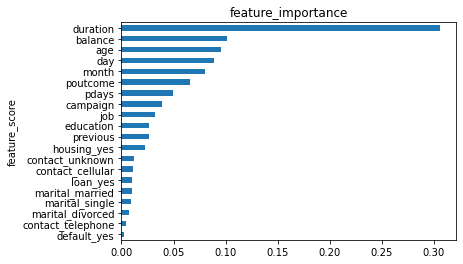

In [ ]:
pd.Series(RF_all.feature_importances_, index=RF_all.feature_names_in_).sort_values(ascending=True).plot(kind='barh', xlabel = 'feature_score', ylabel = 'feature_name', title='feature_importance')